In [37]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import seaborn as sns
import random
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchinfo import summary
from skimage.metrics import structural_similarity as ssim
import tqdm

In [2]:
root = './SIDD_Medium_Srgb/Data/'
dir = os.listdir(root[:-1])
folders=[]
for folder in dir:
  folders.append(folder)

GT = []
Noisy = []
for folder in folders:
  files = os.listdir(root+folder)
  for img in files:
    if img[5]=='G':
      GT.append(root+folder+'/'+img)
    else:
      Noisy.append(root+folder+'/'+img)

In [3]:
df = pd.DataFrame()
df['Ground Truth Images'] = GT
df['Noisy Images'] = Noisy
df.head()

Ground Truth Images  \
0  ./SIDD_Medium_Srgb/Data/0020_001_GP_00800_0035...   
1  ./SIDD_Medium_Srgb/Data/0020_001_GP_00800_0035...   
2  ./SIDD_Medium_Srgb/Data/0072_003_IP_01000_0200...   
3  ./SIDD_Medium_Srgb/Data/0072_003_IP_01000_0200...   
4  ./SIDD_Medium_Srgb/Data/0050_002_N6_03200_0320...   

                                        Noisy Images  
0  ./SIDD_Medium_Srgb/Data/0020_001_GP_00800_0035...  
1  ./SIDD_Medium_Srgb/Data/0020_001_GP_00800_0035...  
2  ./SIDD_Medium_Srgb/Data/0072_003_IP_01000_0200...  
3  ./SIDD_Medium_Srgb/Data/0072_003_IP_01000_0200...  
4  ./SIDD_Medium_Srgb/Data/0050_002_N6_03200_0320...

In [4]:
df.shape

(320, 2)

In [7]:
X = df['Noisy Images']
y = df['Ground Truth Images']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(256,)
(256,)
(64,)
(64,)


In [9]:
def patches(img,patch_size):
  patches = patchify(img, (patch_size, patch_size, 3), step=patch_size)
  return patches

In [10]:
path = df['Ground Truth Images'].iloc[0]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_gt = patches(img,256)
print('Patch shape: {}'.format(patches_gt.shape))

Image shape: (3044, 4048, 3)
Patch shape: (11, 15, 1, 256, 256, 3)


In [11]:
path = df['Noisy Images'].iloc[0]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('Image shape: {}'.format(img.shape))

patches_nsy = patches(img,256)
print('Patch shape: {}'.format(patches_nsy.shape))

Image shape: (3044, 4048, 3)
Patch shape: (11, 15, 1, 256, 256, 3)


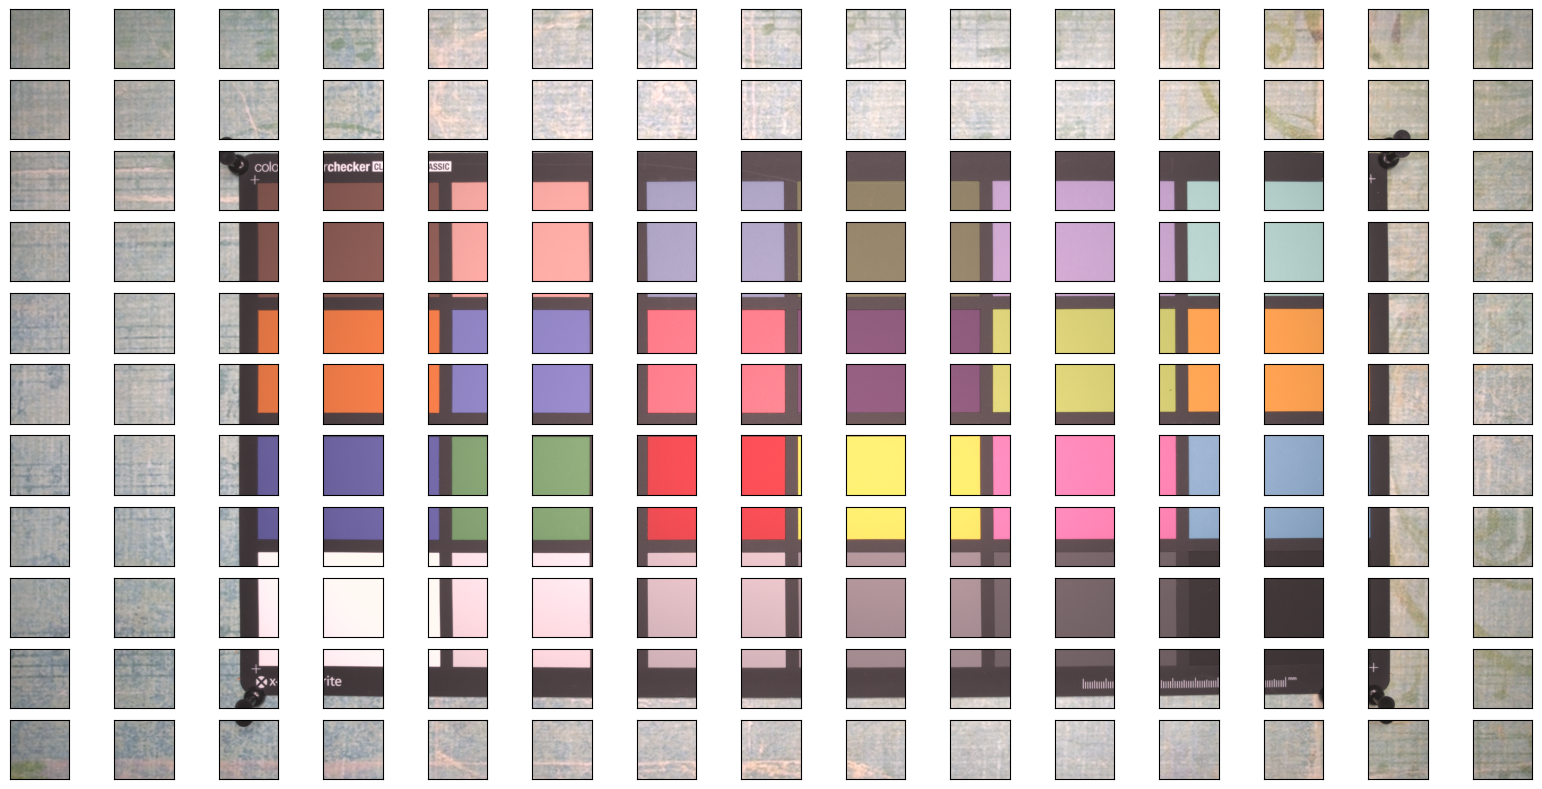

In [12]:
rows = patches_nsy.shape[0]
cols = patches_nsy.shape[1]
fig, axs = plt.subplots(rows,cols,figsize=(20,10))
for i in range(rows):
  for j in range(cols):
    axs[i][j].imshow(patches_gt[i][j][0])
    axs[i][j].get_xaxis().set_visible(False)
    axs[i][j].get_yaxis().set_visible(False)

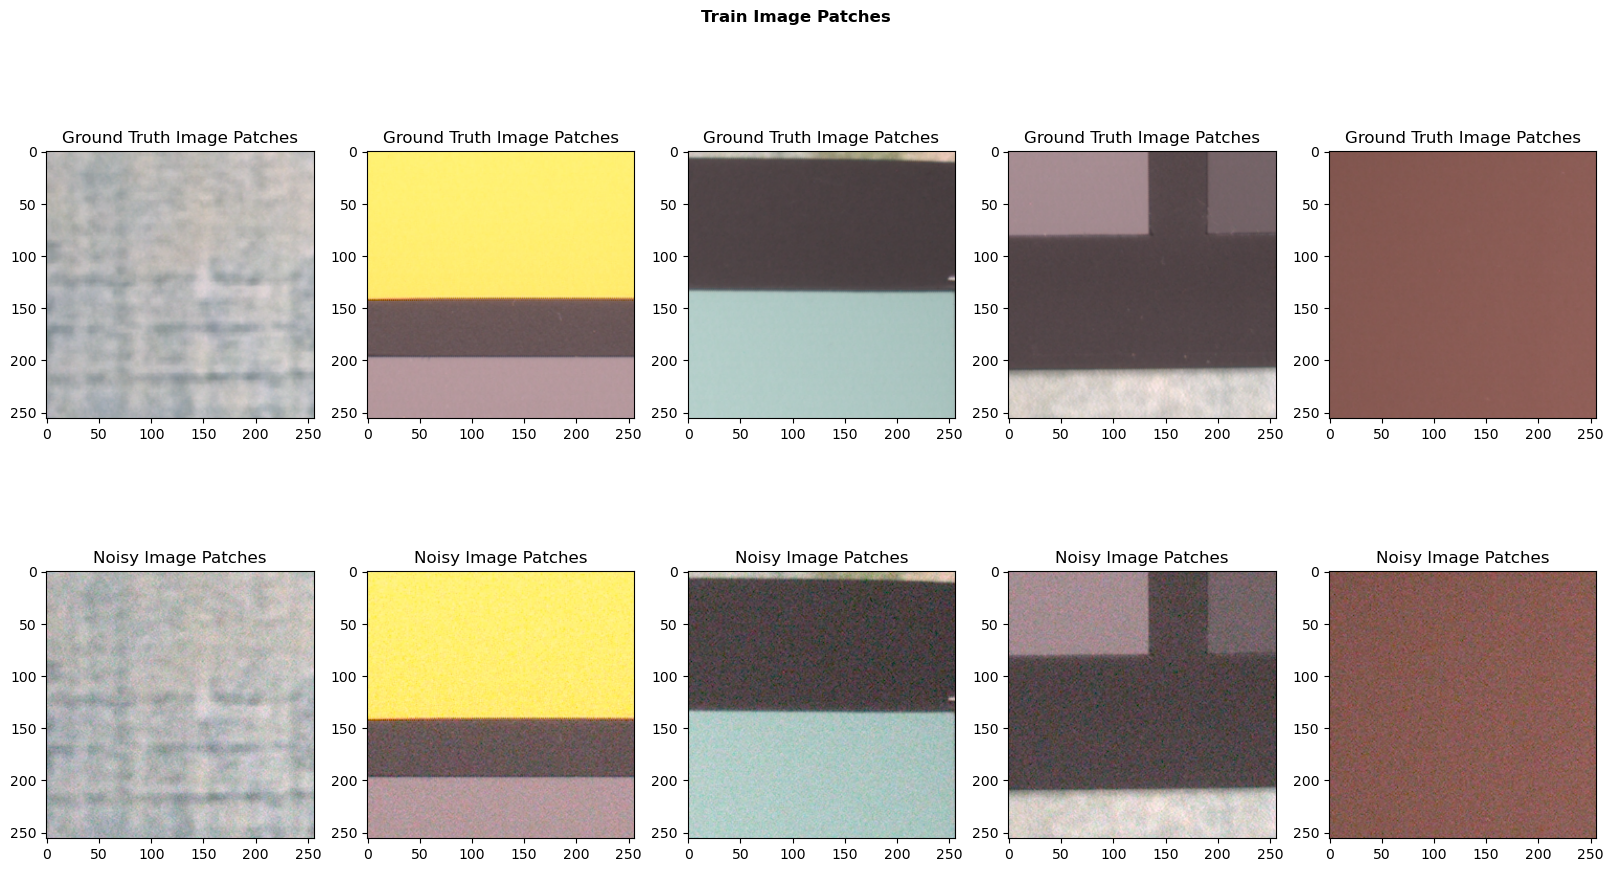

In [13]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, rows), 5)
c = random.sample(range(0, cols), 5)
fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(patches_gt[r[i]][c[i]][0])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(patches_nsy[r[i]][c[i]][0])
  axs[1][i].set_title('Noisy Image Patches')

In [14]:
#Creating patches for X_train and y_train
X_train_patches = []
y_train_patches = []
for i in range(len(X_train)):
  path = X_train.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_train images
  patches_nsy = patches(img_nsy,256)
  
  path = y_train.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_train images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_train_patches.append(patches_nsy[j][k][0])
      y_train_patches.append(patches_gt[j][k][0])
  
X_train = np.array(X_train_patches)
y_train = np.array(y_train_patches)

In [15]:
#Creating patches for X_test and y_test
X_test_patches = []
y_test_patches = []
for i in range(len(X_test)):
  path = X_test.iloc[i]
  img_nsy = cv2.imread(path)
  img_nsy = cv2.cvtColor(img_nsy, cv2.COLOR_BGR2RGB)
  img_nsy = cv2.resize(img_nsy,(1024,1024))  #resizing the X_test images
  patches_nsy = patches(img_nsy,256)
  
  path = y_test.iloc[i]
  img_gt = cv2.imread(path)
  img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
  img_gt = cv2.resize(img_gt,(1024,1024))  #resizing the y_test images
  patches_gt = patches(img_gt,256)

  rows = patches_nsy.shape[0]
  cols = patches_nsy.shape[1]
  for j in range(rows):
    for k in range(cols):
      X_test_patches.append(patches_nsy[j][k][0])
      y_test_patches.append(patches_gt[j][k][0])

X_test = np.array(X_test_patches)
y_test = np.array(y_test_patches)

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4096, 256, 256, 3)
(4096, 256, 256, 3)
(1024, 256, 256, 3)
(1024, 256, 256, 3)


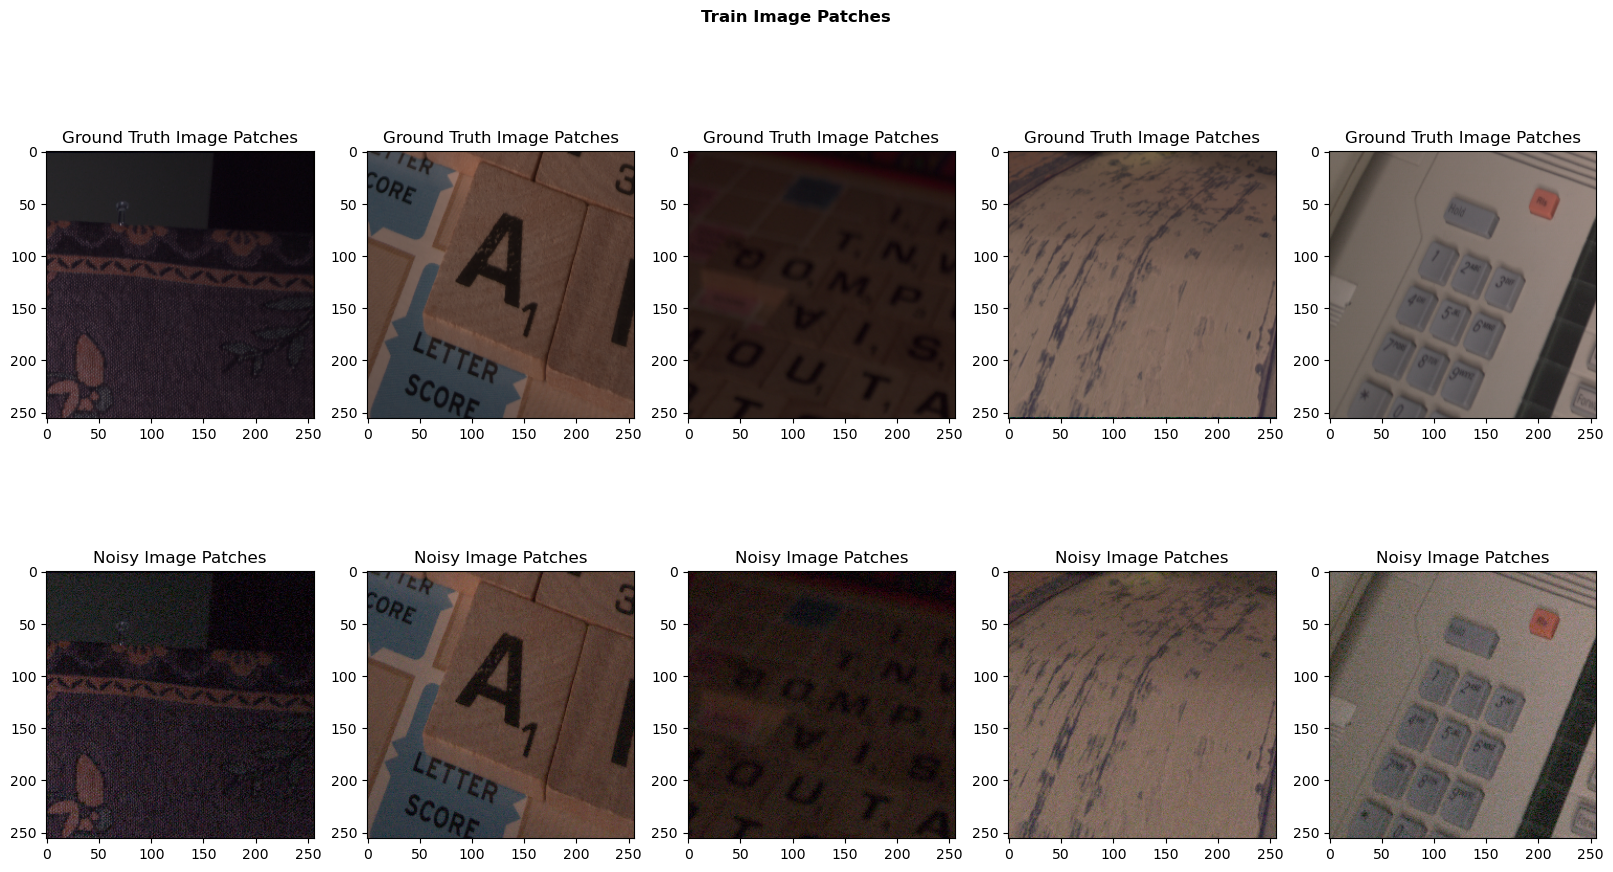

In [17]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, X_train.shape[0]), 5)

fig.suptitle('Train Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_train[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_train[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

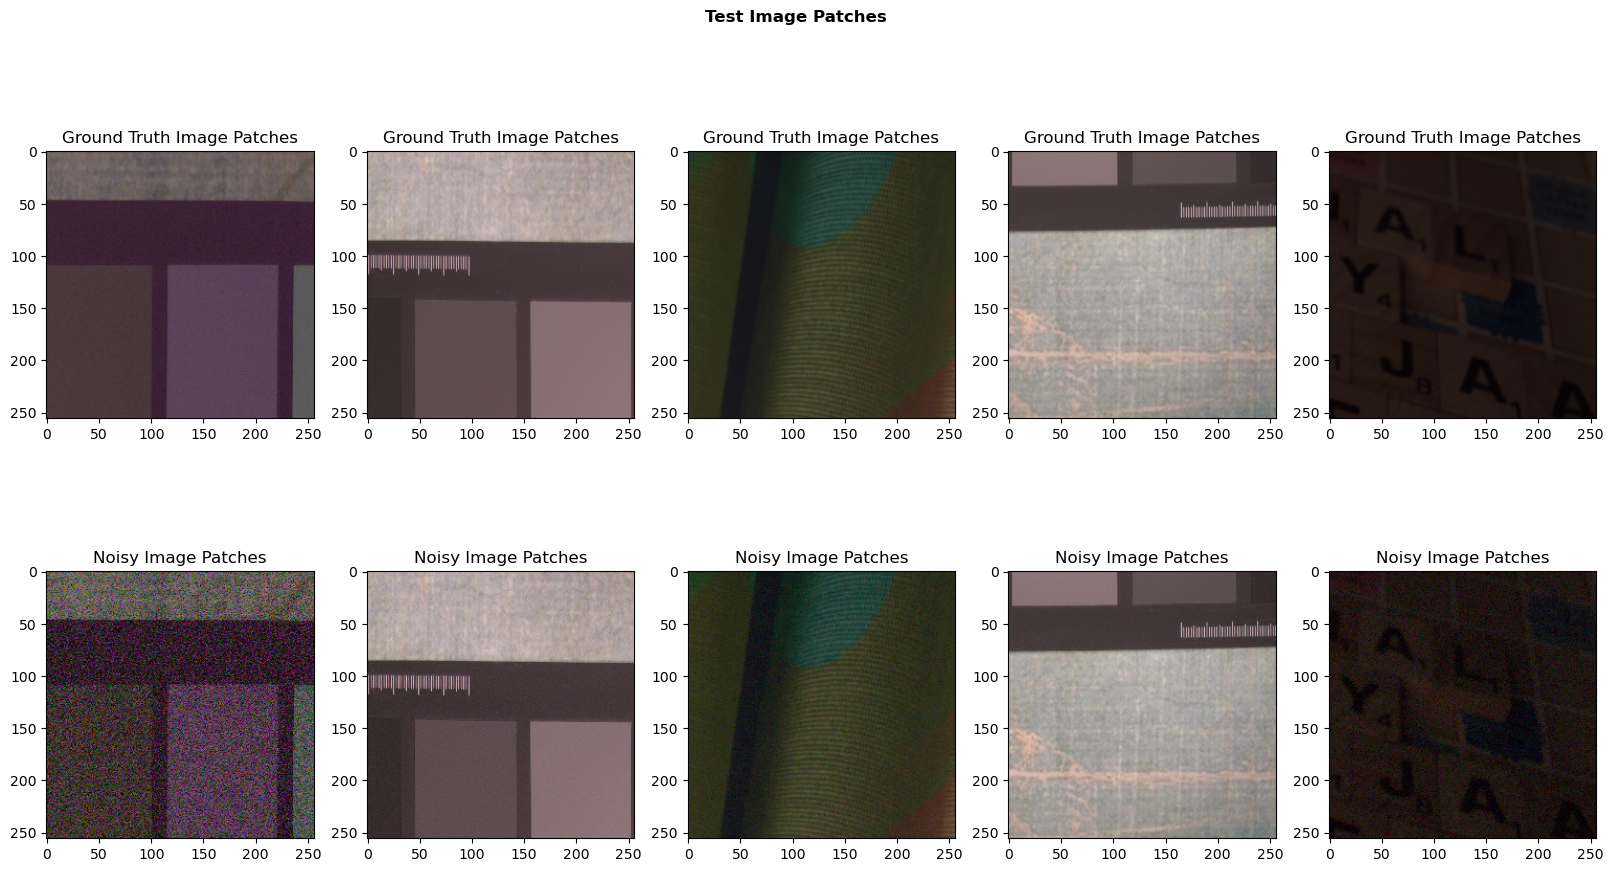

In [18]:
fig, axs = plt.subplots(2,5,figsize=(20,10))
r = random.sample(range(0, X_test.shape[0]), 5)

fig.suptitle('Test Image Patches',fontweight ="bold")
for i in range(5):
  axs[0][i].imshow(y_test[r[i]])
  axs[0][i].set_title('Ground Truth Image Patches')
  axs[1][i].imshow(X_test[r[i]])
  axs[1][i].set_title('Noisy Image Patches')

In [19]:
print("Total number of image patches on train data : ", len(X_train))
print("Total number of image patches on test data : ", len(X_test))

Total number of image patches on train data :  4096
Total number of image patches on test data :  1024


In [ ]:
# #Analyzing the PSNR and SSIM values of the images
# from tqdm import tqdm
# SSIM = [];PSNR = [];
# for i in tqdm(range(len(df))):
#     path = df['Ground Truth Images'].iloc[i]
#     img1 = cv2.imread(path)
#     img1 = img1.astype("float32") / 255.0
#     path = df['Noisy Images'].iloc[i]
#     img2 = cv2.imread(path)
#     img2 = img2.astype("float32") / 255.0
#     SSIM.append(ssim(img1,img2,multichannel=True,data_range=img2.max() - img2.min(),channel_axis=-1))

In [ ]:
# ax = sns.displot(SSIM)
# ax.set(xlabel='SSIM between GT and noisy', ylabel='Count')

In [ ]:
# ssim_count = np.array(SSIM)
# print(len(ssim_count),len(ssim_count[ssim_count > 0.56]))

In [24]:
X_train_patches = X_train.copy()
y_train_patches = y_train.copy()
X_test_patches = X_test.copy()
y_test_patches = y_test.copy()

In [25]:
print(X_train_patches.shape)
print(y_train_patches.shape)
print(X_test_patches.shape)
print(y_test_patches.shape)

(4096, 256, 256, 3)
(4096, 256, 256, 3)
(1024, 256, 256, 3)
(1024, 256, 256, 3)


In [29]:
X_train_patches = np.transpose(X_train_patches, (0,3,1,2))
y_train_patches = np.transpose(y_train_patches, (0,3,1,2))
X_test_patches = np.transpose(X_test_patches, (0,3,1,2))
y_test_patches = np.transpose(y_test_patches, (0,3,1,2))

In [30]:
X_train_patches = X_train_patches.astype("float32") / 255.0
y_train_patches = y_train_patches.astype("float32") / 255.0
X_test_patches = X_test_patches.astype("float32") / 255.0
y_test_patches = y_test_patches.astype("float32") / 255.0

In [31]:
train_patches = TensorDataset(torch.Tensor(X_train_patches),torch.Tensor(y_train_patches))
test_patches = TensorDataset(torch.Tensor(X_test_patches),torch.Tensor(y_test_patches))

In [32]:
batch_size=32
train_loader = DataLoader(train_patches, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_patches, batch_size=batch_size, shuffle=True)

In [33]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3,32,3,1,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,1,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1,padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(128,128,3,2,padding=1,output_padding=1),
            nn.ConvTranspose2d(128,64,3,2,padding=1,output_padding=1),
            nn.ConvTranspose2d(64,32,3,2,padding=1,output_padding=1),
            nn.Conv2d(32,3,3,1,padding='same'),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [34]:
model = AutoEncoder()
print(summary(model, input_size=(batch_size, 3, 256, 256)))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 128, 32, 32]         --
│    └─Conv2d: 2-1                       [32, 32, 256, 256]        896
│    └─ReLU: 2-2                         [32, 32, 256, 256]        --
│    └─MaxPool2d: 2-3                    [32, 32, 128, 128]        --
│    └─Conv2d: 2-4                       [32, 64, 128, 128]        18,496
│    └─ReLU: 2-5                         [32, 64, 128, 128]        --
│    └─MaxPool2d: 2-6                    [32, 64, 64, 64]          --
│    └─Conv2d: 2-7                       [32, 128, 64, 64]         73,856
│    └─ReLU: 2-8                         [32, 128, 64, 64]         --
│    └─MaxPool2d: 2-9                    [32, 128, 32, 32]         --
├─Sequential: 1-2                        [32, 3, 256, 256]         --
│    └─ConvTranspose2d: 2-10             [32, 128, 64, 64]         147,584
│

In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=2,verbose=True)

In [36]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

count_parameters(model)

     864
      32
   18432
      64
   73728
     128
  147456
     128
   73728
      64
   18432
      32
     864
       3
________
  333955


# Train model

In [39]:
epochs = 15

# train_losses = []
# test_losses = []

for i in range(epochs):
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        model.train()
        X_train = X_train.to(device='cuda')
        y_train = y_train.to(device='cuda')
        
        pred = model(X_train)
        loss = criterion(pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 50 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{32*b:6}/{X_train_patches.shape[0]}]  loss: {loss.item():10.8f}')

    # train_losses.append(loss)
    running_loss = 0    
    model.eval()
    with torch.no_grad():
        for vb, (X_test, y_test) in enumerate(test_loader):
            #push data to GPU
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            # Apply the model
            val = model(X_test)
            loss = criterion(val, y_test)
            running_loss += loss
    
    # test_losses.append(loss)
    avg_loss = running_loss / (vb+1)
    print(f'epoch: {i:2}  finished   validation loss: {avg_loss.item():10.8f}')
    scheduler.step(loss)

epoch:  0  batch:   50 [  1600/4096]  loss: 0.00621302
epoch:  0  batch:  100 [  3200/4096]  loss: 0.00465238
epoch:  0  finished   validation loss: 0.00342949
epoch:  1  batch:   50 [  1600/4096]  loss: 0.00203355
epoch:  1  batch:  100 [  3200/4096]  loss: 0.00214427
epoch:  1  finished   validation loss: 0.00208060
epoch:  2  batch:   50 [  1600/4096]  loss: 0.00207483
epoch:  2  batch:  100 [  3200/4096]  loss: 0.00154630
epoch:  2  finished   validation loss: 0.00172008
epoch:  3  batch:   50 [  1600/4096]  loss: 0.00149734
epoch:  3  batch:  100 [  3200/4096]  loss: 0.00191375
epoch:  3  finished   validation loss: 0.00167310
epoch:  4  batch:   50 [  1600/4096]  loss: 0.00182833
epoch:  4  batch:  100 [  3200/4096]  loss: 0.00151300
epoch:  4  finished   validation loss: 0.00153765
epoch:  5  batch:   50 [  1600/4096]  loss: 0.00120295
epoch:  5  batch:  100 [  3200/4096]  loss: 0.00153790
epoch:  5  finished   validation loss: 0.00149088
epoch:  6  batch:   50 [  1600/4096]  lo

PSNR before denoising : 25.30222409671096
PSNR after denoising : 26.84092804807877
SSIM before denoising : 0.5016270778651233
SSIM after denoising : 0.6835773410566617


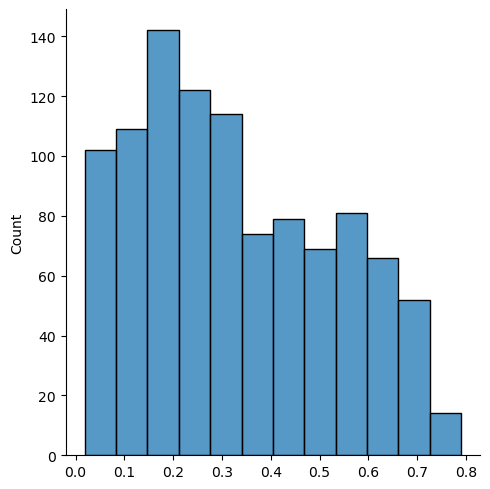

In [40]:
model.eval()
ssim_without_gt = []
ssim_wrt_gt = []
with torch.no_grad():
    psnr_nsy = 0.0
    psnr_de_nsy = 0.0
    ssim_nsy = 0.0
    ssim_de_nsy = 0.0
    
    for X_test, y_test in test_loader:
        X_test = X_test.cuda()
        y_test = y_test.cuda()
        
        y_val = model(X_test)
        # transform to image to compute PSNR

        for GT, NSY, PRED in zip(y_test, X_test, y_val):
            gt = np.transpose(GT.cpu().numpy(),(1,2,0))
            nsy = np.transpose(NSY.cpu().numpy(),(1,2,0))
            pred = np.transpose(PRED.cpu().numpy(),(1,2,0))
            
            psnr_nsy += psnr(gt,nsy,data_range=nsy.max() - nsy.min())
            psnr_de_nsy += psnr(gt,pred,data_range=pred.max() - pred.min())
            ssim_nsy += ssim(gt,nsy,data_range=nsy.max() - nsy.min(),channel_axis=-1)
            ssim_de_nsy += ssim(gt,pred,data_range=pred.max() - pred.min(),channel_axis=-1)
            ssim_without_gt.append(ssim(pred,nsy,data_range=pred.max() - pred.min(),channel_axis=-1))
            ssim_wrt_gt.append(ssim(pred,gt,data_range=pred.max() - pred.min(),channel_axis=-1))
    dataset_size = 1024
    psnr_nsy = psnr_nsy/dataset_size
    psnr_de_nsy = psnr_de_nsy/dataset_size
    ssim_nsy = ssim_nsy/dataset_size
    ssim_de_nsy = ssim_de_nsy/dataset_size

print('PSNR before denoising :', psnr_nsy)
print('PSNR after denoising :', psnr_de_nsy)
print('SSIM before denoising :', ssim_nsy)
print('SSIM after denoising :', ssim_de_nsy)
sns.displot(ssim_without_gt)

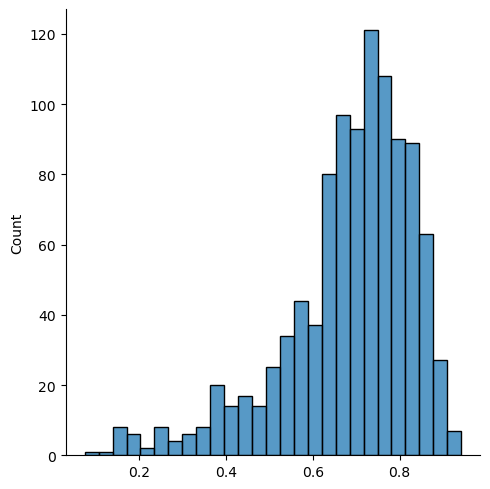

In [41]:
sns.displot(ssim_wrt_gt)

In [42]:
ssim_without_gt_np = np.array(ssim_without_gt)
ssim_wrt_gt_np = np.array(ssim_wrt_gt)
max_acc = -1
max_acc_th = -1

def calc_metrics(tp,tn,fp,fn):
    acc = (tp + tn)/(tp+tn+fp+fn)
    recall = tp/(tp+fn)
    prec = tp/(tp+fp)
    f1 = 2*tp/(2*tp+fp+fn)
    return acc, recall, prec, f1

In [46]:
for threshold in np.arange(1,0,-0.01):
    tn = len(ssim_without_gt_np[ssim_without_gt_np < threshold])
    tp = len(ssim_wrt_gt_np[ssim_wrt_gt_np > threshold])
    fn = len(ssim_wrt_gt_np[ssim_wrt_gt_np < threshold])
    fp = len(ssim_without_gt_np[ssim_without_gt_np > threshold])
    accuracy = (tp + tn)/(tp+tn+fp+fn)
    if accuracy >= max_acc:
        max_acc = accuracy
        max_acc_th = np.round(threshold,2)

In [47]:
tn = len(ssim_without_gt_np[ssim_without_gt_np < max_acc_th])
tp = len(ssim_wrt_gt_np[ssim_wrt_gt_np > max_acc_th])
fn = len(ssim_wrt_gt_np[ssim_wrt_gt_np < max_acc_th])
fp = len(ssim_without_gt_np[ssim_without_gt_np > max_acc_th])
accuracy, recall, precision, f1 = calc_metrics(tp,tn,fp,fn)
print(np.round(max_acc_th,2))
print("Accuracy: ",accuracy)
print("Recall: ",recall)
print("Precision: ",precision)
print("F1: ",f1)

0.57
Accuracy:  0.83251953125
Recall:  0.8232421875
Precision:  0.8388059701492537
F1:  0.8309512074913751
